# Testing

In [5]:
# Simplification of: https://github.com/binance/binance-public-data/tree/master/python

import pandas as pd
from datetime import *
from dateutil.rrule import rrule, MONTHLY

import os, sys
from pathlib import Path
import urllib.request


YEARS = ['2017', '2018', '2019', '2020', '2021']
INTERVALS = ["1m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1mo"]
DAILY_INTERVALS = ["1m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d"]
TRADING_TYPE = ["spot", "um", "cm"]
MONTHS = list(range(1,13))
MAX_DAYS = 35
BASE_URL = 'https://data.binance.vision/'
START_DATE = date(int(YEARS[0]), MONTHS[0], 1)
END_DATE = datetime.date(datetime.now())


def get_destination_dir(file_url, folder=None):
  # store_directory = os.environ.get('STORE_DIRECTORY')
  # if folder:
  #   store_directory = folder
  # if not store_directory:
  #   store_directory = os.path.dirname(os.path.realpath(__file__))
  return os.path.join('', file_url)


def get_download_url(file_url):
  return "{}{}".format(BASE_URL, file_url)


def download_file(base_path, file_name, date_range=None, folder=None):
  download_path = "{}{}".format(base_path, file_name)
  if folder:
    base_path = os.path.join(folder, base_path)
  if date_range:
    date_range = date_range.replace(" ","_")
    base_path = os.path.join(base_path, date_range)
  save_path = get_destination_dir(os.path.join(base_path, file_name), folder)
  

  if os.path.exists(save_path):
    print("\nfile already exists! {}".format(save_path))
    return
  
  # make the directory
  if not os.path.exists(base_path):
    Path(get_destination_dir(base_path)).mkdir(parents=True, exist_ok=True)

  try:
    download_url = get_download_url(download_path)
    dl_file = urllib.request.urlopen(download_url)
    length = dl_file.getheader('content-length')
    if length:
      length = int(length)
      blocksize = max(4096,length//100)

    with open(save_path, 'wb') as out_file:
      dl_progress = 0
      print("\nFile Download: {}".format(save_path))
      while True:
        buf = dl_file.read(blocksize)   
        if not buf:
          break
        dl_progress += len(buf)
        out_file.write(buf)
        done = int(50 * dl_progress / length)
        sys.stdout.write("\r[%s%s]" % ('#' * done, '.' * (50-done)) )    
        sys.stdout.flush()

  except urllib.error.HTTPError:
    print("\nFile not found: {}".format(download_url))
    pass

def convert_to_date_object(d):
  year, month, day = [int(x) for x in d.split('-')]
  date_obj = date(year, month, day)
  return date_obj

def get_path(trading_type, market_data_type, time_period, symbol, interval=None):
  trading_type_path = 'data/spot'
  if trading_type != 'spot':
    trading_type_path = f'data/futures/{trading_type}'
  if interval is not None:
    path = f'{trading_type_path}/{time_period}/{market_data_type}/{symbol.upper()}/{interval}/'
  else:
    path = f'{trading_type_path}/{time_period}/{market_data_type}/{symbol.upper()}/'
  return path


def download_monthly_klines(trading_type, symbols, num_symbols, intervals, years, months, start_date, end_date, folder, checksum):
  current = 0
  date_range = None

  # if start_date and end_date:
  #   date_range = start_date + " " + end_date

  if not start_date:
    start_date = START_DATE
  else:
    start_date = convert_to_date_object(start_date)

  if not end_date:
    end_date = END_DATE
  else:
    end_date = convert_to_date_object(end_date)

  print("Found {} symbols".format(num_symbols))

  for symbol in symbols:
    print("[{}/{}] - start download monthly {} klines ".format(current+1, num_symbols, symbol))
    for interval in intervals:
      for year in years:
        for month in months:
          current_date = convert_to_date_object('{}-{}-01'.format(year, month))
          if current_date >= start_date and current_date <= end_date:
            path = get_path(trading_type, "klines", "monthly", symbol, interval)
            file_name = "{}-{}-{}-{}.zip".format(symbol.upper(), interval, year, '{:02d}'.format(month))
            download_file(path, file_name, date_range, folder)

            if checksum == 1:
              checksum_path = get_path(trading_type, "klines", "monthly", symbol, interval)
              checksum_file_name = "{}-{}-{}-{}.zip.CHECKSUM".format(symbol.upper(), interval, year, '{:02d}'.format(month))
              download_file(checksum_path, checksum_file_name, date_range, folder)

    current += 1


# CUSTOM CODE
def download_data(folder, type='spot', symbols=['BTCUSDT'], intervals=['1m'], years=YEARS, months=MONTHS, startDate=None, endDate=None, checksum=0):
    num_symbols = len(symbols)
    download_monthly_klines(type, symbols, num_symbols, intervals, years, months, startDate, endDate, folder, checksum)


def load_dataframe(folder, start_date, end_date, type='spot', symbol='BTCUSDT', interval='1m'):
  cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_date', 'quote_asset_volume', 'number_of_trades',	'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',	'ignore']
  path = '{}/data/{}/monthly/klines/{}/{}/'.format(folder, type, symbol, interval)

  data = []
  start, end = datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')
  rr = rrule(MONTHLY, dtstart=start, until=end)
  for p in rr:
    file_name = '{}-{}-{}-{:02d}.zip'.format(symbol, interval, p.year, p.month)
    data.append(pd.read_csv(path + file_name, names=cols))
  
  data = pd.concat(data, ignore_index=True)
  data['Date'] = pd.to_datetime(data['Date'], unit='ms')
  data['close_date'] = pd.to_datetime(data['close_date'], unit='ms')
  return data


In [6]:
import torch
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from talib.abstract import Function


class BaseTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


class BaseCandlestickTransform(BaseTransform):
    OPEN = 'Open'
    HIGH = 'High'
    LOW = 'Low'
    CLOSE = 'Close'
    VOLUME = 'Volume'


# Pytorch model transforms
class FilterFeatures(BaseTransform):
    '''
    Devuelve un subset del dataframe de entrada unicamente con las
    features seleccionadas.
    '''
    def __init__(self, features=[]):
        self.features = features

    def transform(self, X):
        return X[self.features].copy()


class RelativeTransform(BaseTransform):
    def __init__(self, ref_col, target_cols):
        self.ref_col = ref_col
        self.target_cols = target_cols
    
    def transform(self, X):
        ref_value = X.iloc[-1][self.ref_col]
        ref_factor = 100 / ref_value
        
        X[self.target_cols] = (X[self.target_cols] * ref_factor) - 100
        return X


class ManualNormalizer(BaseTransform):
    def __init__(self, feature, mean, std):
        self.feature = feature
        self.mean = mean
        self.std = std
    
    def transform(self, X):
        X[self.feature] = (X[self.feature] - self.mean) / self.std
        return X


class ToTensorTransform(BaseTransform):
    def transform(self, X):
        return torch.tensor(X.values).transpose(0, 1)


# Sickit learn model transforms
class TalibBaseTransform(BaseCandlestickTransform):
    '''
    Base Class for using talib functions as transforms
    https://github.com/mrjbq7/ta-lib
    '''
    def __init__(self, func_name, output_name, **kwargs):
        self.func_name = func_name
        self.output_name = output_name
        self.kwargs = kwargs
        self.f = Function(func_name)
    
    def _get_input(self, X):
        inputs = {
            'open': X[self.OPEN],
            'high': X[self.HIGH],
            'low': X[self.LOW],
            'close': X[self.CLOSE],
            'volume': X[self.VOLUME]
        }
        return inputs
    
    def transform(self, X):
        inputs = self._get_input(X)
        output = self.f(inputs, **self.kwargs)
        if len(output) == len(X):
            X[self.output_name] = output
        else:
            names = {k: '{}{}'.format(self.output_name, k) for k in range(len(output))}
            output = pd.DataFrame(output).transpose().rename(columns=names)
            X = pd.concat([X, output], axis=1)
        return X


class MultiPatternTransform(TalibBaseTransform):
    '''
    Transform for adding multiple talib candlestick patterns.
    '''
    def __init__(self, func_names):
        self.func_names = func_names if isinstance(func_names, list) else [func_names]
        self.fs = {func.lower(): Function(func) for func in self.func_names}
    
    def transform(self, X):
        inputs = self._get_input(X)
        for name, f in self.fs.items():
            X[name] = f(inputs)
        return X


class MovingAverageTransform(TalibBaseTransform):
    '''
    DEMA                 Double Exponential Moving Average
    EMA                  Exponential Moving Average
    KAMA                 Kaufman Adaptive Moving Average
    MA                   Moving average
    MAMA                 MESA Adaptive Moving Average
    MAVP                 Moving average with variable period
    SMA                  Simple Moving Average
    T3                   Triple Exponential Moving Average (T3)
    TEMA                 Triple Exponential Moving Average
    TRIMA                Triangular Moving Average
    WMA                  Weighted Moving Average
    '''
    def __init__(self, func_name, timeperiod=30, **kwargs):
        self.func_name = func_name
        self.timeperiod = timeperiod if isinstance(timeperiod, list) else [timeperiod]
        self.output_name = func_name.lower()
        super().__init__(func_name, self.output_name, timeperiod=timeperiod, **kwargs)
    
    def transform(self, X):
        inputs = self._get_input(X)
        for tp in self.timeperiod:
            X['{}{}'.format(self.output_name, tp)] = self.f(inputs, timeperiod=tp)
        return X


class GoldenDeathCrossTransform(BaseCandlestickTransform):
    '''
    Calculates golden cross and death cross for the specified columns.
    '''
    def __init__(self, col_a, col_b):
        self.col_a = col_a
        self.col_b = col_b
        self.base_name = '_{}_{}'.format(col_a, col_b)
    
    def transform(self, X):
        gold = {'index': [], 'data': []}
        death = {'index': [], 'data': []}

        for i in range(1, len(X)):
            r1 = X.iloc[i - 1]
            r2 = X.iloc[i]

            if (r1[self.col_a] < r1[self.col_b] and r2[self.col_a] > r2[self.col_b]):
                gold['index'].append(i)
                gold['data'].append(r2[self.col_a])
            elif (r1[self.col_a] > r1[self.col_b] and r2[self.col_a] < r2[self.col_b]):
                death['index'].append(i)
                death['data'].append(r2[self.col_a])

        X['golden' + self.base_name] = pd.Series(**gold)
        X['death' + self.base_name] = pd.Series(**death)
        return X


class LocalMinMaxBaseTransform(BaseCandlestickTransform):
    '''
    Creates a column with the close values that are local min/max
    in the specified radius.
    '''
    FUNC = None

    def __init__(self, radius=3):
        self.radius = radius
        self.result_name = 'local{}{}'.format(self.FUNC, radius)
    
    def transform(self, X):
        i = self.radius
        result = {'index': [], 'data': []}
        prices = X[self.CLOSE]
        
        while i < (len(X) - self.radius):
            curr = prices.iloc[i]
            limit = getattr(prices.iloc[(i - self.radius):(i + self.radius + 1)], self.FUNC)()
            
            if curr == limit:
                result['index'].append(i)
                result['data'].append(curr)
            
            i += 1 if (curr != limit) else (self.radius + 1)
        
        X[self.result_name] = pd.Series(**result)
        return X


class LocalMinTransform(LocalMinMaxBaseTransform):
    FUNC = 'min'


class LocalMaxTransform(LocalMinMaxBaseTransform):
    FUNC = 'max'


class MovingWindowBaseTransform(BaseCandlestickTransform):
    '''
    Base transform for features based on a moving window over
    some specified column.
    Given one or many window sizes, creates an new feature for each
    one of them, where the calculated value corresponds to the last
    element of the moving window.
    
    *drop_last is usefull for cases when the last n elements of the window
    arent expected to be available in execution time.
    '''
    def __init__(self, steps, values_col, result_name, drop_last=0, run_incomplete=False):
        self.steps = sorted(steps if isinstance(steps, list) else [steps])
        self.values_col = values_col
        self.result_name = result_name
        self.drop_last = drop_last
        self.run_incomplete = run_incomplete
    
    def _get_objective(self, subset):
        pass
    
    def _get_result_name(self, steps):
        return '{}{}'.format(self.result_name, steps)
    
    def transform(self, X):
        values = X[self.values_col]
        results = [X]
        
        for s in self.steps:
            result = {'index': [], 'data': [], 'name': self._get_result_name(s)}
            start = 0 if self.run_incomplete else (s - 1)
            
            for i in range(start, len(X)):
                subset = values[max(0, (i + 1 - s)):(i + 1 - self.drop_last)]
                res_i = self._get_objective(subset)
                
                if res_i is not None:
                    result['index'].append(i)
                    result['data'].append(res_i)
            results.append(pd.Series(**result, dtype='object'))
        X = pd.concat(results, axis=1)
        return X


class HighersLowersBaseTransform(MovingWindowBaseTransform):
    '''
    Transform based on moving windows that checks if the 
    values in the specified column are all ascending/descending
    in the current window.
    '''
    FUNC = None

    def __init__(self, steps, values_col, suffix, radius=2):
        result_name = '{}{}_'.format(self.FUNC, suffix)
        super().__init__(steps, values_col, result_name, drop_last=radius, run_incomplete=False)
    
    def _sorted(self, values):
        for i in range(1, len(values)):
            if self.FUNC == 'higher':
                if values[i] < values[i - 1]:
                    return False
            else:
                if values[i] > values[i - 1]:
                    return False
        return True
    
    def _get_objective(self, subset):
        subset = subset.dropna().tolist()
        return len(subset) if self._sorted(subset) else None


class HighersTransform(HighersLowersBaseTransform):
    FUNC = 'higher'


class LowersTransform(HighersLowersBaseTransform):
    FUNC = 'lower'


class MinMaxBaseTransform(MovingWindowBaseTransform):
    '''
    Transform based on moving window that gets the min/max
    value for the given column in the current window.
    '''
    FUNC = None
    
    def __init__(self, steps, values_col, suffix, radius=2):
        result_name = '{}{}'.format(self.FUNC, suffix)
        super().__init__(steps, values_col, result_name, drop_last=radius, run_incomplete=False)

    def _get_objective(self, subset):
        val = getattr(subset, self.FUNC)()
        return val if val else None


class MinWindowTransform(MinMaxBaseTransform):
    FUNC = 'min'


class MaxWindowTransform(MinMaxBaseTransform):
    FUNC = 'max'


class CountCondTransform(MovingWindowBaseTransform):
    '''
    Transform based on moving window that counts the total
    of elements of the specifiad column that match the given condition
    inside the current window.
    '''
    def __init__(self, steps, values_col, result_name, value, cond='eq', drop_last=0):
        self.value = value
        self.cond = cond
        super().__init__(steps, values_col, result_name, drop_last=drop_last, run_incomplete=False)

    def _get_objective(self, subset):
        if self.cond == 'eq':
            count = (subset == self.value).sum()
        elif self.cond == 'gt':
            count = (subset > self.value).sum()
        elif self.cond == 'lt':
            count = (subset < self.value).sum()
        elif self.cond == 'gte':
            count = (subset >= self.value).sum()
        elif self.cond == 'lte':
            count = (subset <= self.value).sum()
        elif self.cond == 'neq':
            count = (subset != self.value).sum()
        return count


class CountCondCrossTransform(MovingWindowBaseTransform):
    '''
    TBD
    '''
    pass


class SupportResistanceBounceBaseTransform(BaseCandlestickTransform):
    '''
    Transform to spot when close prices bounce on a support/resistance
    as given by the specified column value.
    '''
    TYPE = None

    def __init__(self, base_col, radius=2, bounce_strength=1):
        self.base_col = base_col
        self.radius = radius
        self.bounce_strength = bounce_strength
        self.result_name = '{}{}_{}'.format('sup' if self.TYPE == 'support' else 'res', radius, base_col)
    
    def transform(self, X):
        i = self.radius
        indexes = []
        values = []
        closes = X[self.CLOSE]
        extremes = X[self.HIGH] if self.TYPE == 'resistance' else X[self.LOW]
        base = X[self.base_col]
        
        while i < len(X) - self.radius:
            m, c_l, c_r = extremes.iloc[i], closes.iloc[i - self.radius], closes.iloc[i + self.radius]
            b_m, b_l, b_r = base.iloc[i], base.iloc[i - self.radius], base.iloc[i + self.radius]
            sup = ((self.TYPE == 'support') and (m < b_m) and (c_l > b_l) and (c_r > b_r))
            res = ((self.TYPE != 'support') and (m > b_m) and (c_l < b_l) and (c_r < b_r))
            # dist_cond = (
            #     (self.bounce_strength * abs(m - b_m) < abs(c_l - b_l)) and
            #     (self.bounce_strength * abs(m - b_m) < abs(c_r - b_r))
            # )
            dist_cond = True
            local_end = m == getattr(
                extremes.iloc[(i - self.radius):(i + self.radius + 1)],
                'min' if self.TYPE == 'support' else 'max'
            )()
            if (sup or res) and dist_cond and local_end:
                indexes.append(i)
                values.append(b_m)
                i += self.radius + 1
            else:
                i += 1
        
        X[self.result_name] = pd.Series(values, index=indexes)
        return X


class SupportBounceTransform(SupportResistanceBounceBaseTransform):
    TYPE = 'support'


class ResistanceBounceTransform(SupportResistanceBounceBaseTransform):
    TYPE = 'resistance'


class RowRelativeTransform(BaseCandlestickTransform):
    def __init__(self, target_cols, ref_col=None):
        self.target_cols = target_cols
        self.ref_col = ref_col if ref_col else self.CLOSE
    
    def transform(self, X):
        ref_factors = 100 / X[self.ref_col]
        X[self.target_cols] = (X[self.target_cols].multiply(ref_factors, axis="index")) - 100
        return X


class FilterFeatures(BaseTransform):
    '''
    Devuelve un subset del dataframe de entrada unicamente con las
    features seleccionadas.
    Puede agregar columnas vacías si se seleccionan features
    que no estaban en el dataframe original.
    '''
    def __init__(self, features=[]):
        self.features = features
    
    def transform(self, X):
        return pd.DataFrame({f: X.get(f, pd.Series(index=X.index, name=f)) for f in self.features})


class DropFeatures(BaseTransform):
    '''
    Elimina las features especificadas.
    Opcionalmente se puede elegir eliminar las features que unicamente
    presentan nulls o un valor constante en el dataframe de entrenamiento.
    '''
    def __init__(self, features=[], drop_constant=True):
        self.features = features
        self.drop_constant = drop_constant

    def fit(self, X, y=None):
        self.keep = []
        self.const = []
        self.drop = [f for f in self.features if f in X.columns]

        if self.drop_constant:
            self.const = X.columns[X.nunique(dropna=False) == 1].tolist()
            self.drop = list(set(self.drop + self.const))
        else:
            self.drop = list(set(self.drop))

        self.keep = [f for f in X.columns if f not in self.drop]
        return self

    def transform(self, X):
        X.drop(self.drop, axis=1, inplace=True)
        return X


class NullImputer(BaseTransform):
    def __init__(self, make_copy=False):
        self.make_copy = make_copy

    def transform(self, X):
        if self.make_copy:
            X = X.copy()
        X.fillna(np.nan, inplace=True)
        return X

    
class FeaturesImputer(BaseTransform):
    '''
    Aplica un `SimpleImputer` unicamente a un subconjunto
    de features.
    '''
    def __init__(self, features=[], **kwargs):
        self.features = features
        self.imputer = SimpleImputer(**kwargs)

    def fit(self, X, y=None):
        if self.features == 'all':
            self.features_ = X.columns.tolist()
        else:
            self.features_ = [f for f in self.features if f in X.columns]

        if self.features_:
            sub_X = X[self.features_]
            self.dtypes = sub_X.dtypes
            self.imputer.fit(sub_X, y)
        return self

    def transform(self, X):
        if self.features_:
            sub_X = X[self.features_].astype(self.dtypes)
            res = pd.DataFrame(
                self.imputer.transform(sub_X),
                columns=self.features_, index=X.index
            )
            X[self.features_] = res
        return X


class MultiFeaturesImputer(BaseTransform):
    '''
    Aplica multiples `FeaturesImputer` en un mismo transform.
    '''
    def __init__(self, config=[]):
        self.config = config

    def fit(self, X, y=None):
        self.imputers = [FeaturesImputer(**conf) for conf in self.config]
        for imputer in self.imputers:
            imputer.fit(X, y)
        return self

    def transform(self, X):
        for imputer in self.imputers:
            X = imputer.transform(X)
        return X



In [3]:
import torch
import numpy as np
import mplfinance as fplt
import plotly.graph_objects as go
from torch.utils.data import Dataset, WeightedRandomSampler


PLOT_PARAMS = {
    'type': 'candle',
    'style': 'charles',
    'volume': True,
    'show_nontrading': True
}


def plot_df_simlpe(df):
    df_plot = df.copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def plot_df_interactive(df):
    fig = go.Figure(data=[go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'])])
    fig.update_layout(xaxis_rangeslider_visible=False)
    # fig.show()
    return fig


def plot_by_date(df, min_date, max_date):
    df_plot = df[(df.Open >= min_date) & (df.Open < max_date)].copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def plot_by_idx(df, min_idx, max_idx):
    df_plot = df[(df.index >= min_idx) & (df.index < max_idx)].copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def get_class_weights(ds, n_classes):
    class_counts = {}
    binary = len(ds[0][1].size()) == 0
    for c in range(n_classes):
        class_counts[c] = 0
    
    for _, target in ds:
        if binary:
            class_counts[target.item()] += 1
        else:
            class_counts[torch.argmax(target).item()] += 1
    
    weights = []
    for c in range(n_classes):
        weights.append(1 / class_counts[c])
    
    return tuple(weights)


def get_scaled_class_weights(ds, n_classes):
    class_weights = torch.tensor(get_class_weights(ds, n_classes))
    return torch.max(class_weights) / class_weights


def get_weighted_random_sampler(ds, class_weights):
    sample_weights = []
    binary = len(ds[0][1].size()) == 0
    
    for _, target in ds:
        if binary:
            sample_weights.append(class_weights[target.item()])
        else:
            sample_weights.append(class_weights[torch.argmax(target).item()])
    
    sample_weights = torch.from_numpy(np.array(sample_weights))
    return WeightedRandomSampler(sample_weights, len(sample_weights))


class BaseTradingDataset(Dataset):
    REF_COL = 'Close'
    REF_MAX_COL = 'Close'
    REF_MIN_COL = 'Close'

    def __init__(self, df, transforms, train_window_size=25, pred_window_size=15, stride=1):
        self.df = df
        self.transforms = transforms
        self.train_window_size = train_window_size
        self.pred_window_size = pred_window_size
        self.stride = stride

        self._precomputed_data = None
        self._precomputed_target = None

    def __len__(self):
        full_window = self.train_window_size + self.pred_window_size
        return (len(self.df) - full_window + 1) // self.stride
    
    def get_label_from_target(self, price, target):
        pass

    def _get_data(self, idx, raw=False):
        start = idx * self.stride
        end = start + self.train_window_size
        data = self.df[start:end].copy()
        if not raw:
            data = self.transforms.transform(data)
        return data
    
    def _get_target(self, idx, raw=False):
        start = (idx * self.stride) + self.train_window_size
        end = start + self.pred_window_size
        target = self.df[start:end].copy()
        if not raw:
            price = self.df.iloc[start - 1][self.REF_COL]
            target = self.get_label_from_target(price, target)
        return target

    def precompute_data(self):
        data = []
        for i in range(len(self)):
            data.append(self._get_data(i))
        self._precomputed_data = torch.stack(data)
    
    def precompute_target(self):
        target = []
        for i in range(len(self)):
            target.append(self._get_target(i))
        self._precomputed_target = torch.stack(target)

    def precompute(self):
        self.precompute_data()
        self.precompute_target()
    
    def to(self, device):
        if self._precomputed_data is not None:
            self._precomputed_data = self._precomputed_data.to(device)
        if self._precomputed_target is not None:
            self._precomputed_target = self._precomputed_target.to(device)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise StopIteration
        
        if self._precomputed_data is not None:
            data = self._precomputed_data[idx]
        else:
            data = self._get_data(idx)
        
        if self._precomputed_target is not None:
            target = self._precomputed_target[idx]
        else:
            target = self._get_target(idx)

        # data = torch.tensor(data.values).transpose(0, 1)
        return data, target


class BinaryTradeDataset(BaseTradingDataset):
    def __init__(self, df, transforms, threshold, increase=True, **kwargs):
        super().__init__(df, transforms, **kwargs)
        self.threshold = threshold
        self.increase = increase
    
    def update_target(self, threshold, increase, precompute=True):
        self.threshold = threshold
        self.increase = increase
        
        if precompute:
            self.precompute_target
    
    def get_label_from_target(self, price, target):
        if self.increase:
            max_value = target[self.REF_MAX_COL].max()
            diff = (max_value * 100 / price) - 100
            return torch.tensor((diff > self.threshold) * 1)
        if not self.increase:
            min_value = target[self.REF_MIN_COL].min()
            diff = (min_value * 100 / price) - 100
            return torch.tensor((diff < self.threshold) * 1)


class MulticlassTradeDataset(BaseTradingDataset):
    '''
    Multiclass target with 4 classes:
    Class 1: Upper bound broken without previously breaking lower bound
    Class 2: Lower bound broken without previously breaking upper bound
    Class 3: Else (no bound broken)
    '''
    def __init__(self, df, transforms, sup_threshold, inf_threshold, **kwargs):
        super().__init__(df, transforms, **kwargs)
        self.sup_threshold = sup_threshold
        self.inf_threshold = inf_threshold
    
    def update_target(self, sup_threshold, inf_threshold, precompute=True):
        self.sup_threshold = sup_threshold
        self.inf_threshold = inf_threshold

        if precompute:
            self.precompute_target
    
    def get_label_from_target(self, price, target):
        sup_price = price * (1 + (self.sup_threshold / 100))
        inf_price = price * (1 + (self.inf_threshold / 100))

        over = target[target[self.REF_MAX_COL] > sup_price]
        if not over.empty:
            pos = over.index[0]
            if target[target.index <= pos][self.REF_MIN_COL].min() > inf_price:
                return torch.tensor([1, 0, 0])
        
        if target[self.REF_MIN_COL].min() < inf_price:
            return torch.tensor([0, 1, 0])
            
        return torch.tensor([0, 0, 1])

In [9]:
# download_data('/Users/dirigaray/repos/crypto_bot/data', startDate='2020-01-01', endDate='2021-02-01', intervals=['15m'])

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-01.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-02.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-03.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-04.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-05.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUS

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from crypto_bot.utils import save_obj, load_obj
from crypto_bot.binance.data_utils import download_data, load_dataframe
from crypto_bot.model.data import (BinaryTradeDataset, MulticlassTradeDataset, plot_by_date,
                                   plot_by_idx, plot_df_interactive)

DATA_FOLDER = 'C:/Users/diego/crypto_bot/data'
WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'crypto_bot'

# Download data

In [ ]:
download_data(DATA_FOLDER, startDate='2020-01-01', endDate='2022-01-01', intervals=['1h'])

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-01.zip

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-02.zip


# Load data

In [2]:
train_df = load_dataframe(DATA_FOLDER, '2020-01-01', '2021-10-30', interval='1h')
valid_df = load_dataframe(DATA_FOLDER, '2021-11-01', '2021-12-30', interval='1h')

In [6]:
train_df.shape

(16050, 12)

# Prepare data

In [10]:
from crypto_bot.model.transforms import FilterFeatures, RelativeTransform, ManualNormalizer, ToTensorTransform
from sklearn.pipeline import Pipeline
from crypto_bot.model.data import MulticlassTradeDataset

features = ['Open', 'High', 'Low', 'Close', 'Volume']
transforms = Pipeline([
    ('filter_features', FilterFeatures(features)),
    ('relative_features', RelativeTransform('Close', ['Open', 'High', 'Low', 'Close'])),
    ('normalize_volume', ManualNormalizer('Volume', 253.104670, 294.186058)),
    ('to_tensor', ToTensorTransform()),
])

## Binary/Multiclass dataset

In [11]:
# Binary
train_dataset = BinaryTradeDataset(train_df, transforms, 0.8, stride=3)
valid_dataset = BinaryTradeDataset(valid_df, transforms, 0.8, stride=3)

# # Multiclass
# train_dataset = MulticlassTradeDataset(train_df, transforms, 0.7, -0.3, stride=1)
# valid_dataset = MulticlassTradeDataset(valid_df, transforms, 0.7, -0.3, stride=1)

train_dataset.precompute()
valid_dataset.precompute()

In [14]:
train_ds_name = '{}/data_loaders/train_5m_v1.ds'.format(DATA_FOLDER)
valid_ds_name = '{}/data_loaders/valid_5m_v1.ds'.format(DATA_FOLDER)

# Save
save_obj(train_ds_name, train_dataset)
save_obj(valid_ds_name, valid_dataset)

# # Load
# train_dataset = load_obj(train_ds_name)
# valid_dataset = load_obj(valid_ds_name)

# Tests

In [13]:
# ds = load_dataframe(DATA_FOLDER, '2021-01-01', '2021-03-01', interval='1h')
ds = load_dataframe('/Users/dirigaray/repos/crypto_bot/data', '2021-01-01', '2021-02-28', interval='15m')
ds.shape

(5659, 12)

## Fast test

In [179]:
from sklearn.pipeline import Pipeline
from crypto_bot.model.transforms import (
    TalibBaseTransform, MultiPatternTransform, MovingAverageTransform,
    GoldenDeathCrossTransform, LocalMinTransform, LocalMaxTransform, HighersTransform,
    LowersTransform, MinWindowTransform, MaxWindowTransform, CountCondTransform,
    SupportBounceTransform, ResistanceBounceTransform, RowRelativeTransform,
    DropFeatures
)

# pipe = Pipeline([
#     # Overlap Studies
#     ('EMA', MovingAverageTransform('EMA', timeperiod=[8, 32])),
#     # ('EMA32', MovingAverageTransform('EMA', timeperiod=32)),
#     # ('BOUNCE', SupportBounceTransform('ema_24', 7, 3)),
# ])

cds_features = [
    'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_date',
    'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume', 'ignore'
]

pipe = Pipeline([
    # Local max/min
    ('LOCALMIN', LocalMinTransform(radius=3)),
    ('LOCALMAX', LocalMaxTransform(radius=3)),
    
    # Candle Patterns
    ('CDLPATTERNS', MultiPatternTransform([
        'CDL3OUTSIDE',
        'CDLADVANCEBLOCK',
        'CDLBELTHOLD',
        'CDLCLOSINGMARUBOZU',
        'CDLDOJI',
        'CDLENGULFING',
        'CDLGRAVESTONEDOJI',
        'CDLHAMMER',
        'CDLHANGINGMAN',
        'CDLHARAMI',
        'CDLHIGHWAVE',
        'CDLHIKKAKE',
        'CDLLONGLEGGEDDOJI',
        'CDLLONGLINE',
        'CDLMARUBOZU',
        'CDLMATCHINGLOW',
        'CDLRICKSHAWMAN',
        'CDLSHORTLINE',
    ])),
    
    # Support / Resistance bounce
    ('SUP_SMA', SupportBounceTransform('sma13', radius=2, bounce_strength=1)),
    ('SUP_EMA', SupportBounceTransform('ema21', radius=2, bounce_strength=1)),
    ('SUP_DEMA', SupportBounceTransform('dema55', radius=2, bounce_strength=1)),
    ('RES_SMA', ResistanceBounceTransform('sma13', radius=2, bounce_strength=1)),
    ('RES_EMA', ResistanceBounceTransform('ema21', radius=2, bounce_strength=1)),
    ('RES_DEMA', ResistanceBounceTransform('dema55', radius=2, bounce_strength=1)),

    # Bands
    ('BBANDS_16', TalibBaseTransform('BBANDS', 'bbands16_', timeperiod=16)),
    ('BBANDS_64', TalibBaseTransform('BBANDS', 'bbands64_', timeperiod=64)),

    # Moving avarages
    ('SMA', MovingAverageTransform('SMA', timeperiod=[5, 8, 13])),
    ('EMA', MovingAverageTransform('EMA', timeperiod=[13, 21, 34])),
    ('DEMA', MovingAverageTransform('DEMA', timeperiod=[34, 55, 89])),
    ('MAMA', TalibBaseTransform('MAMA', 'mama')),

    # Momentum
    ('RSI_1', TalibBaseTransform('RSI', 'rsi6', timeperiod=6)),
    ('RSI_2', TalibBaseTransform('RSI', 'rsi14', timeperiod=14)),
    ('MACD', TalibBaseTransform('MACD', 'macd', fastperiod=12, slowperiod=26, signalperiod=9)),
    ('ADX_1', TalibBaseTransform('ADX', 'adx6', timeperiod=6)),
    ('ADX_2', TalibBaseTransform('ADX', 'adx14', timeperiod=14)),
    ('ROC_1', TalibBaseTransform('ROC', 'roc4', timeperiod=4)),
    ('ROC_2', TalibBaseTransform('ROC', 'roc10', timeperiod=10)),
    ('STOCHF', TalibBaseTransform('STOCHF', 'stochf', fastk_period=14, slowk_period=5)),

    # Crosses
    ('MAMA_CROSSES', GoldenDeathCrossTransform('mama0', 'mama1')),
    ('SMA_CROSSES_1', GoldenDeathCrossTransform('sma5', 'sma8')),
    ('SMA_CROSSES_2', GoldenDeathCrossTransform('sma5', 'sma13')),
    ('SMA_CROSSES_3', GoldenDeathCrossTransform('sma8', 'sma13')),
    ('SMA_CROSSES_4', GoldenDeathCrossTransform('sma5', 'ema13')),
    ('SMA_CROSSES_5', GoldenDeathCrossTransform('sma5', 'ema21')),
    ('SMA_CROSSES_6', GoldenDeathCrossTransform('sma8', 'ema34')),
    ('EMA_CROSSES_1', GoldenDeathCrossTransform('ema13', 'ema34')),
    ('EMA_CROSSES_2', GoldenDeathCrossTransform('ema13', 'dema55')),
    ('DEMA_CROSSES_1', GoldenDeathCrossTransform('dema34', 'dema55')),
    ('DEMA_CROSSES_2', GoldenDeathCrossTransform('dema34', 'dema89')),
    ('STOCH_CROSSES', GoldenDeathCrossTransform('stochf0', 'stochf1')),
    
    # Higher / Lower
    ('HIGHER_HIGHS', HighersTransform([16, 32, 64], 'localmax3', 'highs', radius=3)),
    ('HIGHER_LOWS', HighersTransform([16, 32, 64], 'localmin3', 'lows', radius=3)),
    ('LOWER_HIGHS', LowersTransform([16, 32, 64], 'localmax3', 'highs', radius=3)),
    ('LOWER_LOWS', LowersTransform([16, 32, 64], 'localmin3', 'lows', radius=3)),
    ('HIGHER_SMA_1', HighersTransform([8, 16, 32], 'sma5', 'sma5', radius=0)),
    ('HIGHER_SMA_2', HighersTransform([16, 32, 64], 'sma13', 'sma13', radius=0)),
    ('HIGHER_EMA_1', HighersTransform([16, 32, 64], 'ema13', 'ema13', radius=0)),
    ('HIGHER_EMA_2', HighersTransform([32, 64, 128], 'ema34', 'ema34', radius=0)),
    ('LOWERER_SMA_1', LowersTransform([8, 16], 'sma5', 'sma5', radius=0)),
    ('LOWERER_SMA_2', LowersTransform([16, 32], 'sma13', 'sma13', radius=0)),
    ('LOWERER_EMA_1', LowersTransform([16, 32], 'ema13', 'ema13', radius=0)),
    ('LOWERER_EMA_2', LowersTransform([32, 64], 'ema34', 'ema34', radius=0)),
    ('HIGHER_RSI', HighersTransform([3, 5, 8], 'rsi6', 'rsi6', radius=0)),
    ('LOWERER_RSI', LowersTransform([3, 5, 8], 'rsi6', 'rsi6', radius=0)),
    
    # Count local max/min
    ('COUNT_LOCAL_MIN', CountCondTransform([8, 16, 32], 'localmin3', 'count_localmin3', 0, 'gt', drop_last=3)),
    ('COUNT_LOCAL_MAX', CountCondTransform([8, 16, 32], 'localmax3', 'count_localmax3', 0, 'gt', drop_last=3)),
    
    # Count patterns
    ('P100_3OUTSIDE', CountCondTransform([2, 4, 8], 'cdl3outside', 'p100_3outside', 100, 'gte')),
    ('P100_BELTHOLD', CountCondTransform([2, 4, 8], 'cdlbelthold', 'p100_belthold', 100, 'gte')),
    ('P100_CLOSINGMARUBOZU', CountCondTransform([2, 4, 8], 'cdlclosingmarubozu', 'p100_closingmarubozu', 100, 'gte')),
    ('P100_DOJI', CountCondTransform([2, 4, 8], 'cdldoji', 'p100_doji', 100, 'gte')),
    ('P100_ENGULFING', CountCondTransform([2, 4, 8], 'cdlengulfing', 'p100_engulfing', 100, 'gte')),
    ('P100_GRAVESTONEDOJI', CountCondTransform([2, 4, 8], 'cdlgravestonedoji', 'p100_gravestonedoji', 100, 'gte')),
    ('P100_HAMMER', CountCondTransform([2, 4, 8], 'cdlhammer', 'p100_hammer', 100, 'gte')),
    ('P100_HARAMI', CountCondTransform([2, 4, 8], 'cdlharami', 'p100_harami', 100, 'gte')),
    ('P100_HIGHWAVE', CountCondTransform([2, 4, 8], 'cdlhighwave', 'p100_highwave', 100, 'gte')),
    ('P100_HIKKAKE_1', CountCondTransform([2, 4, 8], 'cdlhikkake', 'p100_hikkake', 100, 'gte')),
    ('P100_HIKKAKE_2', CountCondTransform([2, 4, 8], 'cdlhikkake', 'p200_hikkake', 200, 'gte')),
    ('P100_LONGLEGGEDDOJI', CountCondTransform([2, 4, 8], 'cdllongleggeddoji', 'p100_longleggeddoji', 100, 'gte')),
    ('P100_LONGLINE', CountCondTransform([2, 4, 8], 'cdllongline', 'p100_longline', 100, 'gte')),
    ('P100_MARUBOZU', CountCondTransform([2, 4, 8], 'cdlmarubozu', 'p100_marubozu', 100, 'gte')),
    ('P100_MATCHINGLOW', CountCondTransform([2, 4, 8], 'cdlmatchinglow', 'p100_matchinglow', 100, 'gte')),
    ('P100_RICKSHAWMAN', CountCondTransform([2, 4, 8], 'cdlrickshawman', 'p100_rickshawman', 100, 'gte')),
    ('P100_SHORTLINE', CountCondTransform([2, 4, 8], 'cdlshortline', 'p100_shortline', 100, 'gte')),
    ('N100_3OUTSIDE', CountCondTransform([2, 4, 8], 'cdl3outside', 'n100_3outside', -100, 'lte')),
    ('N100_ADVANCEBLOCK', CountCondTransform([2, 4, 8], 'cdladvanceblock', 'n100_advanceblock', -100, 'lte')),
    ('N100_BELTHOLD', CountCondTransform([2, 4, 8], 'cdlbelthold', 'n100_belthold', -100, 'lte')),
    ('N100_CLOSINGMARUBOZU', CountCondTransform([2, 4, 8], 'cdlclosingmarubozu', 'n100_closingmarubozu', -100, 'lte')),
    ('N100_ENGULFING', CountCondTransform([2, 4, 8], 'cdlengulfing', 'n100_engulfing', -100, 'lte')),
    ('N100_HANGINGMAN', CountCondTransform([2, 4, 8], 'cdlhangingman', 'n100_hangingman', -100, 'lte')),
    ('N100_HARAMI', CountCondTransform([2, 4, 8], 'cdlharami', 'n100_harami', -100, 'lte')),
    ('N100_HIGHWAVE', CountCondTransform([2, 4, 8], 'cdlhighwave', 'n100_highwave', -100, 'lte')),
    ('N100_HIKKAKE_1', CountCondTransform([2, 4, 8], 'cdlhikkake', 'n100_hikkake', -100, 'lte')),
    ('N100_HIKKAKE_2', CountCondTransform([2, 4, 8], 'cdlhikkake', 'n200_hikkake', -200, 'lte')),
    ('N100_LONGLINE', CountCondTransform([2, 4, 8], 'cdllongline', 'n100_longline', -100, 'lte')),
    ('N100_MARUBOZU', CountCondTransform([2, 4, 8], 'cdlmarubozu', 'n100_marubozu', -100, 'lte')),
    ('N100_SHORTLINE', CountCondTransform([2, 4, 8], 'cdlshortline', 'n100_shortline', -100, 'lte')),
    
    # Count support / resistance bounces
    ('COUNT_SUP_SMA', CountCondTransform([8, 16, 32], 'sup2_sma13', 'count_sup2_sma13_', 0, 'gt', drop_last=2)),
    ('COUNT_SUP_EMA', CountCondTransform([16, 32, 64], 'sup2_ema21', 'count_sup2_ema21_', 0, 'gt', drop_last=2)),
    ('COUNT_SUP_DEMA', CountCondTransform([16, 32, 64], 'sup2_ema21', 'count_sup2_ema21_', 0, 'gt', drop_last=2)),
    ('COUNT_RES_SMA', CountCondTransform([8, 16, 32], 'res2_sma13', 'count_res2_sma13_', 0, 'gt', drop_last=2)),
    ('COUNT_RES_EMA', CountCondTransform([16, 32], 'res2_ema21', 'count_res2_ema21_', 0, 'gt', drop_last=2)),
    ('COUNT_RES_DEMA', CountCondTransform([16, 32], 'res2_ema21', 'count_res2_ema21_', 0, 'gt', drop_last=2)),

    # # Count crosses
    # ('COUNT_G_MAMA0_MAMA1', CountCondTransform([4, 8, 16], 'golden_mama0_mama1', 'cg_mama0_mama1_', 0, 'gt')),
    # ('COUNT_D_MAMA0_MAMA1', CountCondTransform([4, 8, 16], 'death_mama0_mama1', 'cd_mama0_mama1_', 0, 'gt')),
    # ('COUNT_G_SMA5_SMA8', CountCondTransform([4, 8, 16], 'golden_sma5_sma8', 'cg_sma5_sma8_', 0, 'gt')),
    # ('COUNT_D_SMA5_SMA8', CountCondTransform([4, 8, 16], 'death_sma5_sma8', 'cd_sma5_sma8_', 0, 'gt')),
    # ('COUNT_G_SMA5_SMA13', CountCondTransform([4, 8, 16], 'golden_sma5_sma13', 'cg_sma5_sma13_', 0, 'gt')),
    # ('COUNT_D_SMA5_SMA13', CountCondTransform([4, 8, 16], 'death_sma5_sma13', 'cd_sma5_sma13_', 0, 'gt')),
    # ('COUNT_G_SMA8_SMA13', CountCondTransform([4, 8, 16], 'golden_sma8_sma13', 'cg_sma8_sma13_', 0, 'gt')),
    # ('COUNT_D_SMA8_SMA13', CountCondTransform([4, 8, 16], 'death_sma8_sma13', 'cd_sma8_sma13_', 0, 'gt')),
    # ('COUNT_G_SMA5_EMA13', CountCondTransform([4, 8, 16], 'golden_sma5_ema13', 'cg_sma5_ema13_', 0, 'gt')),
    # ('COUNT_D_SMA5_EMA13', CountCondTransform([4, 8, 16], 'death_sma5_ema13', 'cd_sma5_ema13_', 0, 'gt')),
    # ('COUNT_G_SMA5_EMA21', CountCondTransform([4, 8, 16], 'golden_sma5_ema21', 'cg_sma5_ema21_', 0, 'gt')),
    # ('COUNT_D_SMA5_EMA21', CountCondTransform([4, 8, 16], 'death_sma5_ema21', 'cd_sma5_ema21_', 0, 'gt')),
    # ('COUNT_G_SMA8_EMA34', CountCondTransform([4, 8, 16], 'golden_sma8_ema34', 'cg_sma8_ema34_', 0, 'gt')),
    # ('COUNT_D_SMA8_EMA34', CountCondTransform([4, 8, 16], 'death_sma8_ema34', 'cd_sma8_ema34_', 0, 'gt')),
    # ('COUNT_G_EMA13_EMA34', CountCondTransform([4, 8, 16], 'golden_ema13_ema34', 'cg_ema13_ema34_', 0, 'gt')),
    # ('COUNT_D_EMA13_EMA34', CountCondTransform([4, 8, 16], 'death_ema13_ema34', 'cd_ema13_ema34_', 0, 'gt')),
    # ('COUNT_G_EMA13_DEMA55', CountCondTransform([4, 8, 16], 'golden_ema13_dema55', 'cg_ema13_dema55_', 0, 'gt')),
    # ('COUNT_D_EMA13_DEMA55', CountCondTransform([4, 8, 16], 'death_ema13_dema55', 'cd_ema13_dema55_', 0, 'gt')),
    # ('COUNT_G_DEMA34_DEMA55', CountCondTransform([4, 8, 16], 'golden_dema34_dema55', 'cg_dema34_dema55_', 0, 'gt')),
    # ('COUNT_D_DEMA34_DEMA55', CountCondTransform([4, 8, 16], 'death_dema34_dema55', 'cd_dema34_dema55_', 0, 'gt')),
    # ('COUNT_G_DEMA34_DEMA89', CountCondTransform([4, 8, 16], 'golden_dema34_dema89', 'cg_dema34_dema89_', 0, 'gt')),
    # ('COUNT_D_DEMA34_DEMA89', CountCondTransform([4, 8, 16], 'death_dema34_dema89', 'cd_dema34_dema89_', 0, 'gt')),
    # ('COUNT_G_STOCHF0_STOCHF1', CountCondTransform([4, 8, 16], 'golden_stochf0_stochf1', 'cg_stochf0_stochf1_', 0, 'gt')),
    # ('COUNT_D_STOCHF0_STOCHF1', CountCondTransform([4, 8, 16], 'death_stochf0_stochf1', 'cd_stochf0_stochf1_', 0, 'gt')),

    # Min / Max values
    ('MIN_SMA', MinWindowTransform([16, 64, 128], 'sma13', 'sma13_', radius=0)),
    ('MAX_SMA', MaxWindowTransform([16, 64, 128], 'sma13', 'sma13_', radius=0)),
    ('MIN_SUP_SMA', MinWindowTransform([5, 8, 16], 'sup2_sma13', 'supsma_', radius=2)),
    ('MIN_RES_SMA', MinWindowTransform([8, 16, 32], 'res2_sma13', 'ressma_', radius=2)),
    ('MIN_SUP_EMA', MinWindowTransform([5, 8, 16], 'sup2_ema21', 'supema_', radius=2)),
    ('MIN_RES_EMA', MinWindowTransform([8, 16, 32], 'res2_ema21', 'resema_', radius=2)),    

    ('MIN_G_MAMA', MinWindowTransform([2, 4], 'golden_mama0_mama1', 'gmama0_mama1_', radius=0)),
    ('MIN_D_MAMA', MinWindowTransform([4], 'death_mama0_mama1', 'dmama0_mama1_', radius=0)),
    ('MIN_G_SMA1', MinWindowTransform([2, 4], 'golden_sma5_sma8', 'gsma5_sma8_', radius=0)),
    ('MIN_D_SMA1', MinWindowTransform([4], 'death_sma5_sma8', 'dsma5_sma8_', radius=0)),
    ('MIN_G_SMA2', MinWindowTransform([2, 4], 'golden_sma5_sma13', 'gsma5_sma13_', radius=0)),
    ('MIN_D_SMA2', MinWindowTransform([4], 'death_sma5_sma13', 'dsma5_sma13_', radius=0)),
    ('MIN_G_SMA3', MinWindowTransform([2, 4], 'golden_sma8_sma13', 'gsma8_sma13_', radius=0)),
    ('MIN_D_SMA3', MinWindowTransform([4], 'death_sma8_sma13', 'dsma8_sma13_', radius=0)),
    ('MIN_G_SMA4', MinWindowTransform([2, 4], 'golden_sma5_ema13', 'gsma5_ema13_', radius=0)),
    ('MIN_D_SMA4', MinWindowTransform([4], 'death_sma5_ema13', 'dsma5_ema13_', radius=0)),
    ('MIN_G_SMA5', MinWindowTransform([2, 4], 'golden_sma5_ema21', 'gsma5_ema21_', radius=0)),
    ('MIN_D_SMA5', MinWindowTransform([4], 'death_sma5_ema21', 'dsma5_ema21_', radius=0)),
    ('MIN_G_SMA6', MinWindowTransform([2, 4], 'golden_sma8_ema34', 'gsma8_ema34_', radius=0)),
    ('MIN_D_SMA6', MinWindowTransform([4], 'death_sma8_ema34', 'dsma8_ema34_', radius=0)),
    ('MIN_G_EMA1', MinWindowTransform([2, 4], 'golden_ema13_ema34', 'gema13_ema34_', radius=0)),
    ('MIN_D_EMA1', MinWindowTransform([4], 'death_ema13_ema34', 'dema13_ema34_', radius=0)),
    ('MIN_G_EMA2', MinWindowTransform([2, 4], 'golden_ema13_dema55', 'gema13_dema55_', radius=0)),
    ('MIN_D_EMA2', MinWindowTransform([4], 'death_ema13_dema55', 'dema13_dema55_', radius=0)),
    ('MIN_G_DEMA1', MinWindowTransform([2, 4], 'golden_dema34_dema55', 'gdema34_dema55_', radius=0)),
    ('MIN_D_DEMA1', MinWindowTransform([4], 'death_dema34_dema55', 'ddema34_dema55_', radius=0)),
    ('MIN_G_DEMA2', MinWindowTransform([2, 4], 'golden_dema34_dema89', 'gdema34_dema89_', radius=0)),
    ('MIN_D_DEMA2', MinWindowTransform([4], 'death_dema34_dema89', 'ddema34_dema89_', radius=0)),
    ('MIN_G_STOCH', MinWindowTransform([2, 4], 'golden_stochf0_stochf1', 'gstochf0_stochf1_', radius=0)),
    ('MIN_D_STOCH', MinWindowTransform([4], 'death_stochf0_stochf1', 'dstochf0_stochf1_', radius=0)),

    # Relative prices
    ('RELATIVE', RowRelativeTransform([
        'bbands16_0',
        'bbands16_1',
        'bbands16_2',
        'bbands64_0',
        'bbands64_1',
        'bbands64_2',
        'sma5',
        'sma8',
        'sma13',
        'ema13',
        'ema21',
        'ema34',
        'dema34',
        'dema55',
        'dema89',
        'mama0',
        'mama1',
        'minsma13_16',
        'minsma13_64',
        'minsma13_128',
        'maxsma13_16',
        'maxsma13_64',
        'maxsma13_128',
        'minsupsma_5',
        'minsupsma_8',
        'minsupsma_16',
        'minressma_8',
        'minressma_16',
        'minressma_32',
        'minsupema_5',
        'minsupema_8',
        'minsupema_16',
        'minresema_8',
        'minresema_16',
        'minresema_32',
        'mingmama0_mama1_3',
        'mingmama0_mama1_5',
        'mingsma5_sma8_3',
        'mingsma5_sma8_5',
        'mingsma5_sma13_3',
        'mingsma5_sma13_5',
        'mingsma8_sma13_3',
        'mingsma8_sma13_5',
        'mingsma5_ema13_3',
        'mingsma5_ema13_5',
        'mingsma5_ema21_3',
        'mingsma5_ema21_5',
        'mingsma8_ema34_3',
        'mingsma8_ema34_5',
        'mingema13_ema34_3',
        'mingema13_ema34_5',
        'mingema13_dema55_3',
        'mingema13_dema55_5',
        'mingdema34_dema55_3',
        'mingdema34_dema55_5',
        'mingdema34_dema89_3',
        'mingdema34_dema89_5',
    ])),
    
    ('DROP_FEATURES', DropFeatures(cds_features + [
        'localmin3',
        'localmax3',
        'cdl3outside',
        'cdladvanceblock',
        'cdlbelthold',
        'cdlclosingmarubozu',
        'cdldoji',
        'cdlengulfing',
        'cdlgravestonedoji',
        'cdlhammer',
        'cdlhangingman',
        'cdlharami',
        'cdlhighwave',
        'cdlhikkake',
        'cdllongleggeddoji',
        'cdllongline',
        'cdlmarubozu',
        'cdlmatchinglow',
        'cdlrickshawman',
        'cdlshortline',
        'sup2_sma13',
        'sup2_ema21',
        'sup2_dema55',
        'res2_sma13',
        'res2_ema21',
        'res2_dema55',
        'golden_mama0_mama1',
        'death_mama0_mama1',
        'golden_sma5_sma8',
        'death_sma5_sma8',
        'golden_sma5_sma13',
        'death_sma5_sma13',
        'golden_sma8_sma13',
        'death_sma8_sma13',
        'golden_sma5_ema13',
        'death_sma5_ema13',
        'golden_sma5_ema21',
        'death_sma5_ema21',
        'golden_sma8_ema34',
        'death_sma8_ema34',
        'golden_ema13_ema34',
        'death_ema13_ema34',
        'golden_ema13_dema55',
        'death_ema13_dema55',
        'golden_dema34_dema55',
        'death_dema34_dema55',
        'golden_dema34_dema89',
        'death_dema34_dema89',
        'golden_stochf0_stochf1',
        'death_stochf0_stochf1',
    ])),
])

In [180]:
dst = pipe.fit_transform(ds[:400].copy())

In [150]:
l1 = [
    'bbands16_0',
    'bbands16_1',
    'bbands16_2',
    'bbands64_0',
    'bbands64_1',
    'bbands64_2',
    'sma5',
    'sma8',
    'sma13',
    'ema13',
    'ema21',
    'ema34',
    'dema34',
    'dema55',
    'dema89',
    'mama0',
    'mama1',
    'sup2_sma13',
    'sup2_ema21',
    'sup2_dema55',
    'res2_sma13',
    'res2_ema21',
    'res2_dema55',
    'golden_mama0_mama1',
    'death_mama0_mama1',
    'golden_sma5_sma8',
    'death_sma5_sma8',
    'golden_sma5_sma13',
    'death_sma5_sma13',
    'golden_sma8_sma13',
    'death_sma8_sma13',
    'golden_sma5_ema13',
    'death_sma5_ema13',
    'golden_sma5_ema21',
    'death_sma5_ema21',
    'golden_sma8_ema34',
    'death_sma8_ema34',
    'golden_ema13_ema34',
    'death_ema13_ema34',
    'golden_ema13_dema55',
    'death_ema13_dema55',
    'golden_dema34_dema55',
    'death_dema34_dema55',
    'golden_dema34_dema89',
    'death_dema34_dema89',
    'minsma13_16',
    'minsma13_64',
    'minsma13_128',
    'maxsma13_16',
    'maxsma13_64',
    'maxsma13_128',
]

In [194]:
fs

['bbands16_0',
 'bbands16_1',
 'bbands16_2',
 'bbands64_0',
 'bbands64_1',
 'bbands64_2',
 'sma5',
 'sma8',
 'sma13',
 'ema13',
 'ema21',
 'ema34',
 'dema34',
 'dema55',
 'dema89',
 'mama0',
 'mama1',
 'sup2_sma13',
 'sup2_ema21',
 'sup2_dema55',
 'res2_sma13',
 'res2_ema21',
 'res2_dema55',
 'rsi6',
 'rsi14',
 'macd0',
 'macd1',
 'macd2',
 'adx6',
 'adx14',
 'roc4',
 'roc10',
 'stochf0',
 'stochf1',
 'golden_mama0_mama1',
 'death_mama0_mama1',
 'golden_sma5_sma8',
 'death_sma5_sma8',
 'golden_sma5_sma13',
 'death_sma5_sma13',
 'golden_sma8_sma13',
 'death_sma8_sma13',
 'golden_sma5_ema13',
 'death_sma5_ema13',
 'golden_sma5_ema21',
 'death_sma5_ema21',
 'golden_sma8_ema34',
 'death_sma8_ema34',
 'golden_ema13_ema34',
 'death_ema13_ema34',
 'golden_ema13_dema55',
 'death_ema13_dema55',
 'golden_dema34_dema55',
 'death_dema34_dema55',
 'golden_dema34_dema89',
 'death_dema34_dema89',
 'golden_stochf0_stochf1',
 'death_stochf0_stochf1',
 'higherhighs_16',
 'higherhighs_32',
 'higherlows_1

In [181]:
len(dst.columns.tolist())

241

In [182]:
fs = dst.columns.tolist()

In [6]:
# dst_b = dst.copy()

In [191]:
sfs = fs[40:50]

In [199]:
dst[['golden_sma8_sma13', 'mingsma8_sma13_5']][215:225]

,golden_sma8_sma13,mingsma8_sma13_5
215,NaN,NaN
216,NaN,NaN
217,-1.336602,-1.336602
218,NaN,-0.863637
219,NaN,0.682153
220,NaN,0.617715
221,NaN,0.345649
222,-0.752980,-0.75298
223,NaN,-0.932371
224,NaN,-0.49461


In [198]:
dst[sfs][215:225]

,golden_sma8_sma13,death_sma8_sma13,golden_sma5_ema13,death_sma5_ema13,golden_sma5_ema21,death_sma5_ema21,golden_sma8_ema34,death_sma8_ema34,golden_ema13_ema34,death_ema13_ema34
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,-1.336602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,0.164965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,-0.752980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,NaN,NaN,NaN,-0.926748,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,-0.252849,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
b = 30667.22
t = 32406.728
(t * 100 / b )- 100

5.672206349320206

In [ ]:
ref_factors = 100 / X[self.ref_col]
        X[self.target_cols] = (X[self.target_cols] * ref_factors) - 100

In [95]:
ref = dst['Close']

In [109]:
dst[['sup2_dema55',
        'res2_sma13',
        'res2_ema21',
        'res2_dema55',]][160:200]

,sup2_dema55,res2_sma13,res2_ema21,res2_dema55
160,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN
162,-2.465606,NaN,NaN,NaN
163,NaN,NaN,NaN,NaN
164,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN
166,NaN,NaN,NaN,NaN
167,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN
169,NaN,NaN,NaN,NaN


In [98]:
dst[['maxsma1316', 'maxsma1364', 'maxsma13128']] = (dst[['maxsma1316', 'maxsma1364', 'maxsma13128']].multiply(ref, axis="index")) - 100

In [90]:
dst[['count_sup2_sma13_8',
        'count_sup2_sma13_16',
        'count_sup2_sma13_32',
        'count_sup2_ema21_16',
        'count_sup2_ema21_32',
        'count_sup2_ema21_64',
        'count_sup2_ema21_16',
        'count_sup2_ema21_32',
        'count_sup2_ema21_64',
        'count_res2_sma13_8',
        'count_res2_sma13_16',
        'count_res2_sma13_32',
        'count_res2_ema21_16',
        'count_res2_ema21_32',
        'count_res2_ema21_16',
        'count_res2_ema21_32',
        'cg_mama0_mama1_4',
        'cg_mama0_mama1_8',
        'cg_mama0_mama1_16',
        'cd_mama0_mama1_4',
        'cd_mama0_mama1_8',
        'cd_mama0_mama1_16',
        'cg_sma5_sma8_4',
        'cg_sma5_sma8_8',
        'cg_sma5_sma8_16',
        'cd_sma5_sma8_4',
        'cd_sma5_sma8_8',
        'cd_sma5_sma8_16',
        'cg_sma5_sma13_4',
        'cg_sma5_sma13_8',
        'cg_sma5_sma13_16',
        'cd_sma5_sma13_4',
        'cd_sma5_sma13_8',
        'cd_sma5_sma13_16',
        'cg_sma8_sma13_4',
        'cg_sma8_sma13_8',
        'cg_sma8_sma13_16',
        'cd_sma8_sma13_4',
        'cd_sma8_sma13_8',
        'cd_sma8_sma13_16',
        'cg_sma5_ema13_4',
        'cg_sma5_ema13_8',
        'cg_sma5_ema13_16',
        'cd_sma5_ema13_4',
        'cd_sma5_ema13_8',
        'cd_sma5_ema13_16',
        'cg_sma5_ema21_4',
        'cg_sma5_ema21_8',
        'cg_sma5_ema21_16',
        'cd_sma5_ema21_4',
        'cd_sma5_ema21_8',
        'cd_sma5_ema21_16',
        'cg_sma8_ema34_4',
        'cg_sma8_ema34_8',
        'cg_sma8_ema34_16',
        'cd_sma8_ema34_4',
        'cd_sma8_ema34_8',
        'cd_sma8_ema34_16',
        'cg_ema13_ema34_4',
        'cg_ema13_ema34_8',
        'cg_ema13_ema34_16',
        'cd_ema13_ema34_4',
        'cd_ema13_ema34_8',
        'cd_ema13_ema34_16',
        'cg_ema13_dema55_4',
        'cg_ema13_dema55_8',
        'cg_ema13_dema55_16',
        'cd_ema13_dema55_4',
        'cd_ema13_dema55_8',
        'cd_ema13_dema55_16',
        'cg_dema34_dema55_4',
        'cg_dema34_dema55_8',
        'cg_dema34_dema55_16',
        'cd_dema34_dema55_4',
        'cd_dema34_dema55_8',
        'cd_dema34_dema55_16',
        'cg_dema34_dema89_4',
        'cg_dema34_dema89_8',
        'cg_dema34_dema89_16',
        'cd_dema34_dema89_4',
        'cd_dema34_dema89_8',
        'cd_dema34_dema89_16',
        'cg_stochf0_stochf1_4',
        'cg_stochf0_stochf1_8',
        'cg_stochf0_stochf1_16',
        'cd_stochf0_stochf1_4',
        'cd_stochf0_stochf1_8',
        'cd_stochf0_stochf1_16',]][56:90]

,count_sup2_sma13_8,count_sup2_sma13_16,count_sup2_sma13_32,count_sup2_ema21_16,count_sup2_ema21_16,count_sup2_ema21_32,count_sup2_ema21_32,count_sup2_ema21_64,count_sup2_ema21_64,count_sup2_ema21_16,...,cg_dema34_dema89_16,cd_dema34_dema89_4,cd_dema34_dema89_8,cd_dema34_dema89_16,cg_stochf0_stochf1_4,cg_stochf0_stochf1_8,cg_stochf0_stochf1_16,cd_stochf0_stochf1_4,cd_stochf0_stochf1_8,cd_stochf0_stochf1_16
56,0,1,3,1,1,2,2,0,0,1,...,0,0,0,0,0,1,3,1,2,3
57,0,1,3,1,1,2,2,0,0,1,...,0,0,0,0,0,1,2,1,2,3
58,0,1,3,1,1,2,2,0,0,1,...,0,0,0,0,0,1,2,1,2,3
59,0,1,3,1,1,2,2,0,0,1,...,0,0,0,0,1,2,3,1,1,2
60,0,1,2,1,1,1,1,0,0,1,...,0,0,0,0,1,1,3,1,2,3
61,0,0,2,0,0,1,1,0,0,0,...,0,0,0,0,1,1,3,1,2,3
62,0,0,2,0,0,1,1,0,0,0,...,0,0,0,0,1,1,2,1,2,3
63,0,0,2,0,0,1,1,3,3,0,...,0,0,0,0,0,1,2,1,2,3
64,0,0,2,0,0,1,1,3,3,0,...,0,0,0,0,0,1,2,0,1,3
65,0,0,2,0,0,1,1,3,3,0,...,0,0,0,0,0,1,2,0,1,3


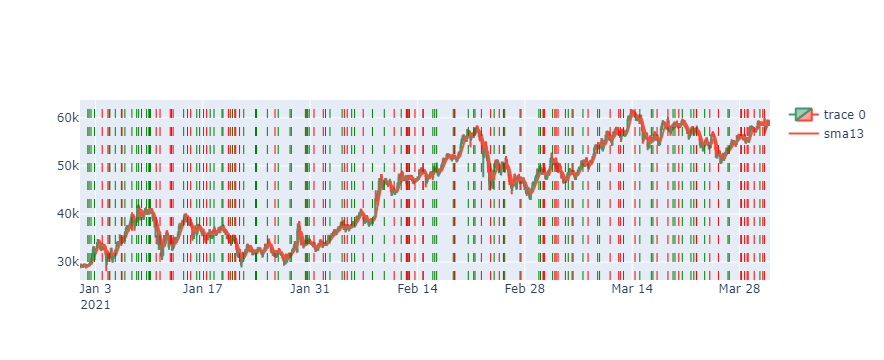

In [59]:
import plotly.graph_objects as go

sub = dst
# center = 1424
# radius = 60
# sub = dst[center - radius:center + radius + 1].copy()
fig = plot_df_interactive(sub)

cols = ['sma13']
for col in cols:
    fig.add_trace(go.Scatter(x=sub['Date'], y=sub[col], type='scatter', mode='lines', name=col))

vlines = {'sup2_sma13': 'green', 'res2_sma13': 'red'}
for col, color in vlines.items():
    for d in sub[~sub[col].isna()]['Date']:
        fig.add_vline(x=d, line_width=1, line_dash="dash", line_color=color)
fig.show()

In [433]:
Function('CDL2CROWS')

{'name': 'CDL2CROWS', 'group': 'Pattern Recognition', 'display_name': 'Two Crows', 'function_flags': ['Output is a candlestick'], 'input_names': OrderedDict([('prices', ['open', 'high', 'low', 'close'])]), 'parameters': OrderedDict(), 'output_flags': OrderedDict([('integer', ['Line'])]), 'output_names': ['integer']}

In [304]:
f = Function('BBANDS')
inputs = {
    'open': ds['Open'],
    'high': ds['High'],
    'low': ds['Low'],
    'close': ds['Close'],
    'volume': ds['Volume']
}
r = f(inputs)
rr = pd.DataFrame(r).transpose()

## Dev Pipeline

In [30]:
pipe = Pipeline([
    # Overlap Studies
    ('BBANDS16', TalibBaseTransform('BBANDS', 'bbands16', timeperiod=16)),
    ('BBANDS64', TalibBaseTransform('BBANDS', 'bbands64', timeperiod=64)),

    ('SMA', MovingAverageTransform('SMA', timeperiod=[5, 8, 13])),
    ('EMA', MovingAverageTransform('EMA', timeperiod=[8, 13, 21])),
    ('DEMA', MovingAverageTransform('DEMA', timeperiod=[13, 21, 34])),
    ('MAMA', MovingAverageTransform('MAMA', timeperiod=[8, 32, 64])),

])

In [ ]:
CDL2CROWS            Two Crows
CDL3BLACKCROWS       Three Black Crows
CDL3INSIDE           Three Inside Up/Down
CDL3LINESTRIKE       Three-Line Strike
CDL3OUTSIDE          Three Outside Up/Down
CDL3STARSINSOUTH     Three Stars In The South
CDL3WHITESOLDIERS    Three Advancing White Soldiers
CDLABANDONEDBABY     Abandoned Baby
CDLADVANCEBLOCK      Advance Block
CDLBELTHOLD          Belt-hold
CDLBREAKAWAY         Breakaway
CDLCLOSINGMARUBOZU   Closing Marubozu
CDLCONCEALBABYSWALL  Concealing Baby Swallow
CDLCOUNTERATTACK     Counterattack
CDLDARKCLOUDCOVER    Dark Cloud Cover
CDLDOJI              Doji
CDLDOJISTAR          Doji Star
CDLDRAGONFLYDOJI     Dragonfly Doji
CDLENGULFING         Engulfing Pattern
CDLEVENINGDOJISTAR   Evening Doji Star
CDLEVENINGSTAR       Evening Star
CDLGAPSIDESIDEWHITE  Up/Down-gap side-by-side white lines
CDLGRAVESTONEDOJI    Gravestone Doji
CDLHAMMER            Hammer
CDLHANGINGMAN        Hanging Man
CDLHARAMI            Harami Pattern
CDLHARAMICROSS       Harami Cross Pattern
CDLHIGHWAVE          High-Wave Candle
CDLHIKKAKE           Hikkake Pattern
CDLHIKKAKEMOD        Modified Hikkake Pattern
CDLHOMINGPIGEON      Homing Pigeon
CDLIDENTICAL3CROWS   Identical Three Crows
CDLINNECK            In-Neck Pattern
CDLINVERTEDHAMMER    Inverted Hammer
CDLKICKING           Kicking
CDLKICKINGBYLENGTH   Kicking - bull/bear determined by the longer marubozu
CDLLADDERBOTTOM      Ladder Bottom
CDLLONGLEGGEDDOJI    Long Legged Doji
CDLLONGLINE          Long Line Candle
CDLMARUBOZU          Marubozu
CDLMATCHINGLOW       Matching Low
CDLMATHOLD           Mat Hold
CDLMORNINGDOJISTAR   Morning Doji Star
CDLMORNINGSTAR       Morning Star
CDLONNECK            On-Neck Pattern
CDLPIERCING          Piercing Pattern
CDLRICKSHAWMAN       Rickshaw Man
CDLRISEFALL3METHODS  Rising/Falling Three Methods
CDLSEPARATINGLINES   Separating Lines
CDLSHOOTINGSTAR      Shooting Star
CDLSHORTLINE         Short Line Candle
CDLSPINNINGTOP       Spinning Top
CDLSTALLEDPATTERN    Stalled Pattern
CDLSTICKSANDWICH     Stick Sandwich
CDLTAKURI            Takuri (Dragonfly Doji with very long lower shadow)
CDLTASUKIGAP         Tasuki Gap
CDLTHRUSTING         Thrusting Pattern
CDLTRISTAR           Tristar Pattern
CDLUNIQUE3RIVER      Unique 3 River
CDLUPSIDEGAP2CROWS   Upside Gap Two Crows
CDLXSIDEGAP3METHODS 